In [1]:
from __future__ import division

import os
import urllib, cStringIO

import pymongo as pm

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

### setup

In [199]:
# directory & file hierarchy
proj_dir = os.path.abspath('../../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis','python') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis','python'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
# Assign variables within imported analysis helpers
import df_generation_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'df_generation_helpers' from '/Users/judithfan/graphical_conventions/analysis/python/df_generation_helpers.pyc'>

In [133]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['3dObjects']
coll = db['graphical_conventions']

# which iteration name should we use?
iterationName = 'run5_submitButton'

## list of researcher mturk worker ID's to ignore
jefan = ['A1MMCS8S8CTWKU','A1MMCS8S8CTWKV','A1MMCS8S8CTWKS']
hawkrobe = ['A1BOIDKD33QSDK']
megsano = ['A1DVQQLVZR7W6I']
researchers = jefan + hawkrobe + megsano 

In [222]:
## get total number of stroke and clickedObj events in the collection as a whole
S = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'stroke'}]}).sort('time')
C = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'clickedObj'}]}).sort('time')

print str(S.count()) + ' stroke records in the database.'
print str(C.count()) + ' clickedObj records in the database.' 

16258 stroke records in the database.
2044 clickedObj records in the database.


In [268]:
from IPython.display import clear_output
reload(h)
## get list of all candidate games
games = coll.find({'iterationName':iterationName}).distinct('gameid')

## get list of complete and valid games
run5_complete_games = h.get_complete_and_valid_games(games,coll,iterationName,researchers=researchers, tolerate_undefined_worker=False)

There are 64 complete games in total.


In [269]:
reload(h)
## generate actual dataframe and get only valid games (filtering out games with low accuracy, timeouts)
D_run5 = h.generate_dataframe(coll, run5_complete_games, iterationName, csv_dir)

Done!


In [351]:
## load in run5 dataframe (no viewer timing feedback)
D = pd.read_csv(os.path.join(csv_dir,'graphical_conventions_group_data_{}.csv'.format(iterationName)))
D = D.assign(category_subset = pd.Series(D['category'] + D['subset']))
D = D.assign(category_subset_condition = pd.Series(D['category'] + D['subset'] + D['condition']))

#### load in original run3/run4 experiment (with viewer timing feedback)
D0 = pd.read_csv(os.path.join(csv_dir,'graphical_conventions.csv'))


In [354]:
## detect low accuracy games
def detect_outlier_games(D,criterion='3sd'):
    dacc = D.groupby('gameID')['outcome'].mean().reset_index()
    acc = dacc['outcome']    
    if criterion=='iqr':
        lq = np.percentile(acc,25)
        uq = np.percentile(acc,75)
        IQR = uq - lq
        lb = lq - 1.5*IQR
        ub = uq + 1.5*IQR
        outlier_games = dacc[dacc['outcome'] < lb]['gameID'].values
    elif criterion=='3sd':
        mu = np.mean(acc)
        sd = np.std(acc)
        lb = mu - 3*sd
        outlier_games = dacc[dacc['outcome'] < lb]['gameID'].values 
    return outlier_games

def filter_outlier_games(D,outlier_games):
    return D[~D['gameID'].isin(outlier_games)]

##################################################
filter_outliers = True
if filter_outliers:
    outlier_games = detect_outlier_games(D)
    print 'There were {} outlier games: {}'.format(len(outlier_games),list(outlier_games))    
    D = filter_outlier_games(D,outlier_games)
    print 'Filtered outlier games.'
    
    outlier_games = detect_outlier_games(D0)    
    print 'There were {} outlier games: {}'.format(len(outlier_games),list(outlier_games))    
    D0 = filter_outlier_games(D0,outlier_games)
    print 'Filtered outlier games.'    

There were 0 outlier games: []
Filtered outlier games.
There were 0 outlier games: []
Filtered outlier games.


In [355]:
### print how many games using each context combinations have run
d = []
w = []
g = []
for name, group in D.groupby('gameID'):
    d.append(sorted(group['category_subset_condition'].unique())[0])
    w.append(sorted(group['category_subset_condition'].unique())[1])
    g.append(name)
C = pd.DataFrame([d,w,g])
C = C.transpose()
C.columns = ['dining','waiting','gameID']
C = C.assign(version=C['dining']+C['waiting'])
Counter(C.version.values)

Counter({'diningAcontrolwaitingArepeated': 8,
         'diningAcontrolwaitingBrepeated': 4,
         'diningArepeatedwaitingAcontrol': 8,
         'diningArepeatedwaitingBcontrol': 6,
         'diningBcontrolwaitingArepeated': 9,
         'diningBcontrolwaitingBrepeated': 10,
         'diningBrepeatedwaitingAcontrol': 7,
         'diningBrepeatedwaitingBcontrol': 10})

(0, 18)

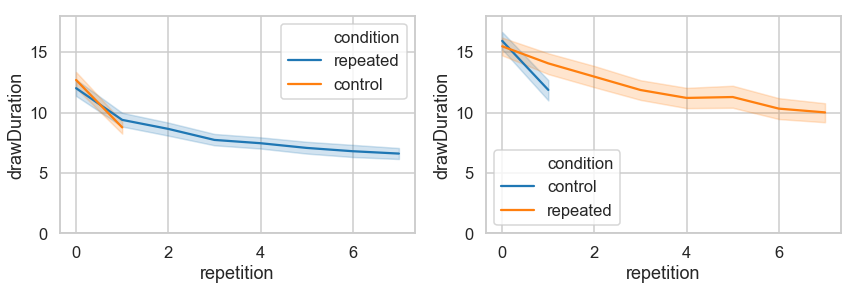

In [356]:
# D.groupby(['gameID','condition'])['outcome'].mean()
sns.set_context('talk')
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.lineplot(x='repetition',hue='condition',y='drawDuration',data=D0)
plt.ylim(0,18)
plt.subplot(122)
sns.lineplot(x='repetition',hue='condition',y='drawDuration',data=D)
plt.ylim(0,18)

(0, 10)

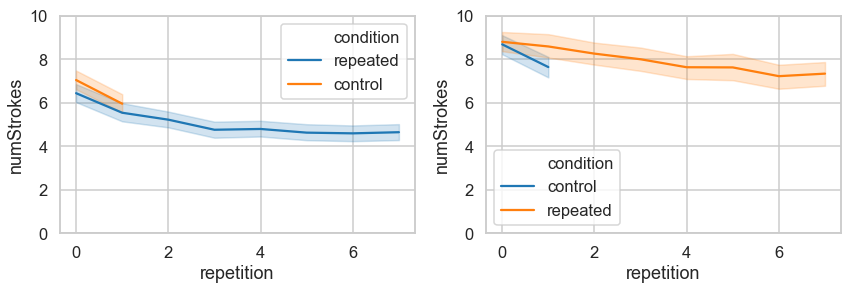

In [357]:
# D.groupby(['gameID','condition'])['outcome'].mean()
sns.set_context('talk')
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.lineplot(x='repetition',hue='condition',y='numStrokes',data=D0)
plt.ylim(0,10)
plt.subplot(122)
sns.lineplot(x='repetition',hue='condition',y='numStrokes',data=D)
plt.ylim(0,10)

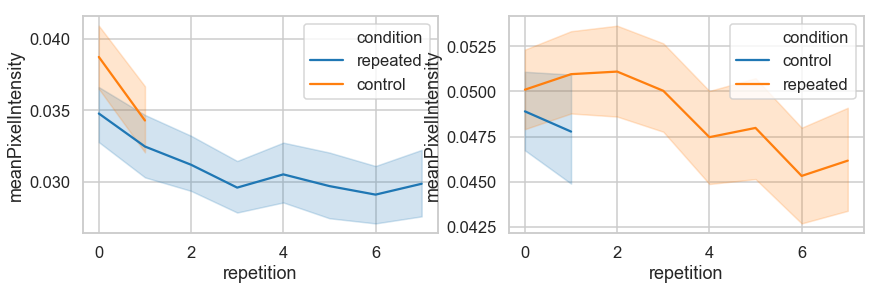

In [359]:
# D.groupby(['gameID','condition'])['outcome'].mean()
sns.set_context('talk')
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.lineplot(x='repetition',hue='condition',y='meanPixelIntensity',data=D0)
# plt.ylim(0,10)
plt.subplot(122)
sns.lineplot(x='repetition',hue='condition',y='meanPixelIntensity',data=D)
# plt.ylim(0,10)

(0, 1)

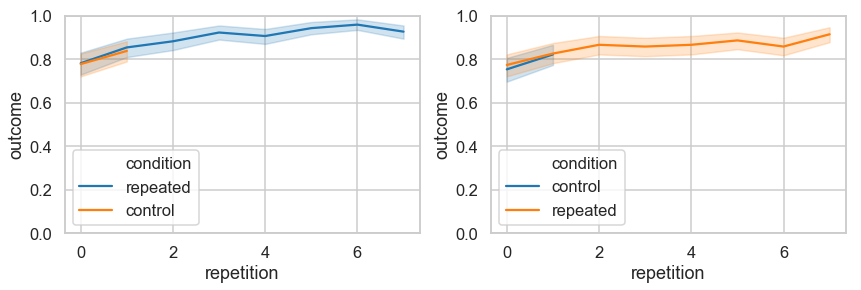

In [360]:
# D.groupby(['gameID','condition'])['outcome'].mean()
sns.set_context('talk')
sns.set_style('whitegrid')
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.lineplot(x='repetition',hue='condition',y='outcome',data=D0)
plt.ylim(0,1)
plt.subplot(122)
sns.lineplot(x='repetition',hue='condition',y='outcome',data=D)
plt.ylim(0,1)

<Figure size 288x288 with 0 Axes>

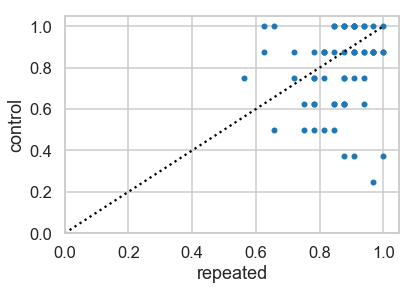

In [362]:
fig = plt.figure(figsize=(4,4))
D2 = D.groupby(['gameID','condition'])['outcome'].mean().reset_index()
D3 = D2.pivot(index='gameID',columns='condition',values='outcome').reset_index()
D3.plot.scatter(x='repeated',
                y='control')
plt.xlim(0,1.05)
plt.ylim(0,1.05)
plt.plot([0,1],[0,1],'k:')

In [363]:
D3 = D3.assign(diff=D3['repeated']-D3['control'])

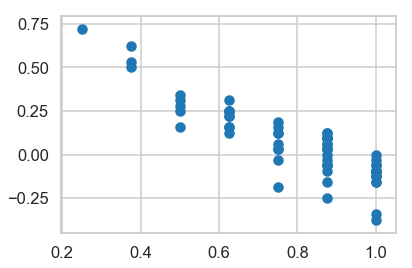

In [364]:
s = plt.scatter(D3['control'],D3['diff'])

In [365]:
print np.mean(D3.repeated.values)
print np.std(D3.repeated.values)

0.8568548387096774
0.09874916851821337


In [366]:
x = D.groupby('gameID')['outcome'].mean()
print np.mean(x), np.std(x)

0.8431451612903228 0.09137936641069004


In [ ]:
## ['dining','waiting']
## ['A','B']
## ['repeated','control']